# Plotting with ASTE

In [1]:
import numpy as np
from matplotlib import cm
import cartopy as cart

In [2]:
# those modules are developped at LDEO 
import xmitgcm
import MITgcm_recipes

In [3]:
# ASTE grid information
# we need extra metadata for xmitgcm to figure it out
astemd = xmitgcm.utils.get_extra_metadata(domain='aste', nx=270)

In [4]:
astemd

{'has_faces': True,
 'ny': 1350,
 'nx': 270,
 'ny_facets': [450, 0, 270, 180, 450],
 'pad_before_y': [90, 0, 0, 0, 0],
 'pad_after_y': [0, 0, 0, 90, 90],
 'face_facets': [0, 0, 2, 3, 4, 4],
 'facet_orders': ['C', 'C', 'C', 'F', 'F'],
 'face_offsets': [0, 1, 0, 0, 0, 1],
 'transpose_face': [False, False, False, True, True, True]}

In [15]:
# ASTE run from An
dir_aste_diags = '/local/data/artemis/simulations/ASTE/r1/diags/'
dir_aste_grid  = '/local/data/artemis/simulations/ASTE/r1/grid/'

ds_aste = xmitgcm.open_mdsdataset(dir_aste_diags, prefix=['state_3d_set1',
                                                          'state_2d_set1',
                                                          'trsp_3d_set1'],
                                  geometry='llc', nx=270, read_grid=True,
                                  grid_dir=dir_aste_grid, extra_metadata=astemd, 
                                  delta_t=1200, ref_date='2002-1-1 0:0:0')

In [16]:
ds_aste

<xarray.Dataset>
Dimensions:   (face: 6, i: 270, i_g: 270, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 193)
Coordinates:
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l       (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1      (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face      (face) int64 0 1 2 3 4 5
    XC        (face, j, i) >f4 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    YC        (face, j, i) >f4 dask.array<shape=(6, 270, 270), chunksize=(1, 270, 270)>
    X

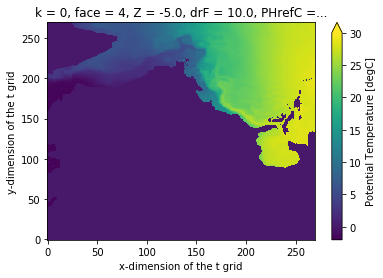

In [13]:
ds_aste.sel(k=0, time='2004-12')['THETA'].sel(face=4).plot(vmin=-2, vmax=30)

## Scalar variables

Let's plot the SST for december 2004

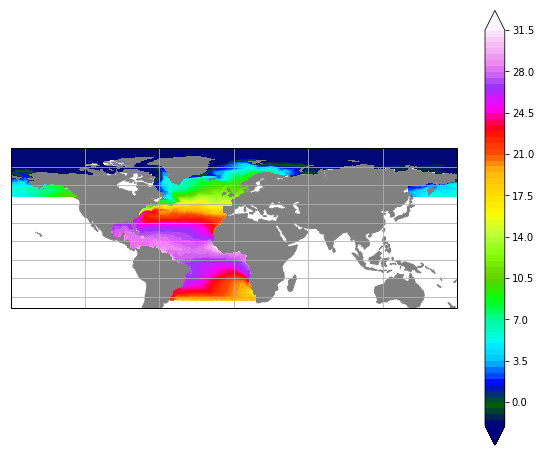

In [14]:
sst_2004_12 = ds_aste['THETA'].sel(k=0, time='2004-12')

dict_plt_sst = {'figsize': [10, 10], 'vmin': -2,'vmax': 32, 
                'contours': np.arange(-2,32,0.5), 
                'cmap': cm.gist_ncar, 'cbarsize': 0.8, 
                'title': 'SST Dec 2004'}

fig = MITgcm_recipes.plot_ASTE_pyresample(sst_2004_12, 
                                          dict_plt_sst, 
                                          proj=cart.crs.PlateCarree())

## Velocities

First we need to rotate the velocities. This will use xgcm. To allow xgcm to perform operation on llc grid, we need to provide how the faces connect to each other with MITgcm_recipes built-in function.

In [19]:
face_connections = MITgcm_recipes.utils.define_faces_connection_ASTE()

In [20]:
face_connections

{'face': {0: {'Y': (None, (1, 'Y', False))},
  1: {'Y': ((0, 'Y', False), (2, 'X', False))},
  2: {'X': ((1, 'Y', False), (3, 'X', False)), 'Y': (None, (4, 'X', False))},
  3: {'X': ((2, 'X', False), None)},
  4: {'X': ((2, 'Y', False), (5, 'X', False))},
  5: {'X': ((4, 'X', False), None)}}}

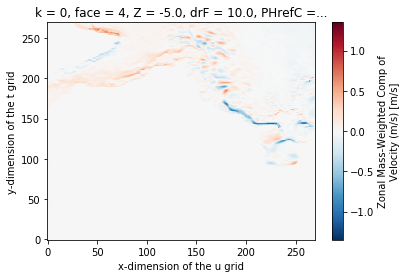

In [18]:
ds_aste.sel(k=0, time='2002-12', face=4)['UVELMASS'].plot()

In [22]:
u1 = ds_aste['UVELMASS'].sel(k=0, time='2004-12')
v1 = ds_aste['VVELMASS'].sel(k=0, time='2004-12')

u_geo, v_geo = MITgcm_recipes.spatial.rotate_llc_to_geo(u1, v1, ds_aste, 
                                                        face_connections)

Add back to the dataset to keep the grid info.

In [23]:
ds_aste['u_geo'] = u_geo
ds_aste['v_geo'] = v_geo

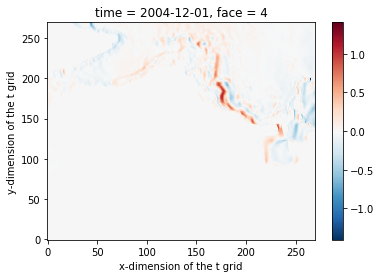

In [32]:
u_geo.isel(face=4).plot()

### zonal velocity

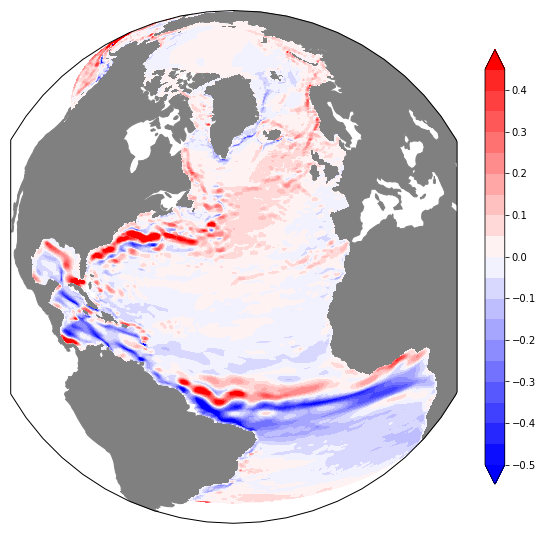

In [35]:
dict_plt_vel = {'figsize': [10, 10], 'vmin': -0.5,'vmax': 0.5, 
                'contours': np.arange(-0.5,0.5,0.05), 
                'cmap': cm.bwr, 'cbarsize': 0.8, 
                'title': ''}

fig = MITgcm_recipes.plot_ASTE_pyresample(u_geo, 
                                          dict_plt_vel, 
                                          proj=cart.crs.Orthographic(
                                              central_longitude=-40,
                                              central_latitude=35))

### Meridional velocity

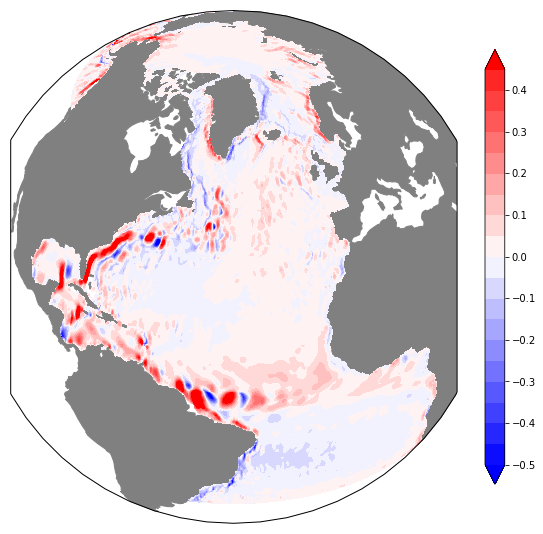

In [10]:
dict_plt_vel = {'figsize': [10, 10], 'vmin': -0.5,'vmax': 0.5, 
                'contours': np.arange(-0.5,0.5,0.05), 
                'cmap': cm.bwr, 'cbarsize': 0.8, 
                'title': ''}

fig = MITgcm_recipes.plot_ASTE_pyresample(v_geo, 
                                          dict_plt_vel, 
                                          proj=cart.crs.Orthographic(
                                              central_longitude=-40,
                                              central_latitude=35))

### Total velocity

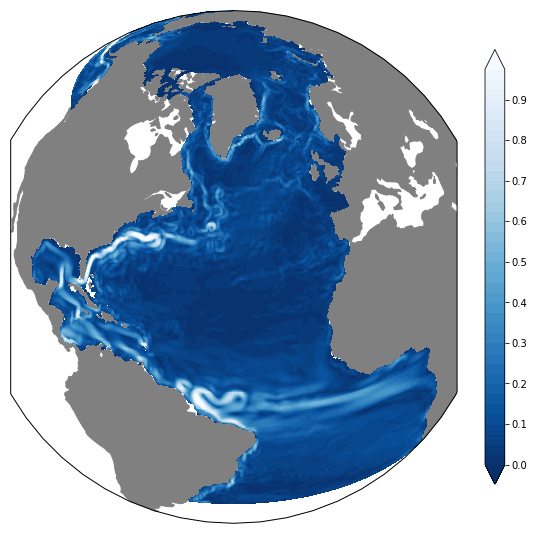

In [11]:
dict_plt_vel = {'figsize': [10, 10], 'vmin': 0,'vmax': 1, 
                'contours': np.arange(0.,1.,0.025), 
                'cmap': cm.Blues_r, 'cbarsize': 0.8, 
                'title': ''}

fig = MITgcm_recipes.plot_ASTE_pyresample(np.sqrt(u_geo**2 + v_geo**2), 
                                          dict_plt_vel, 
                                          proj=cart.crs.Orthographic(
                                              central_longitude=-40,
                                              central_latitude=35))

In [40]:
clim = ds_aste.sel(time=slice('2014', '2016')).mean(dim='time')

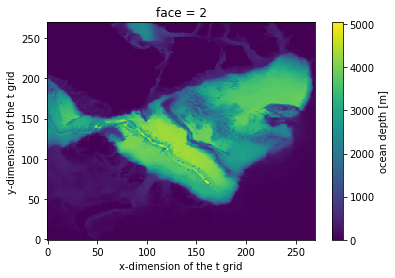

In [46]:
clim['Depth'].sel(face=2).plot()

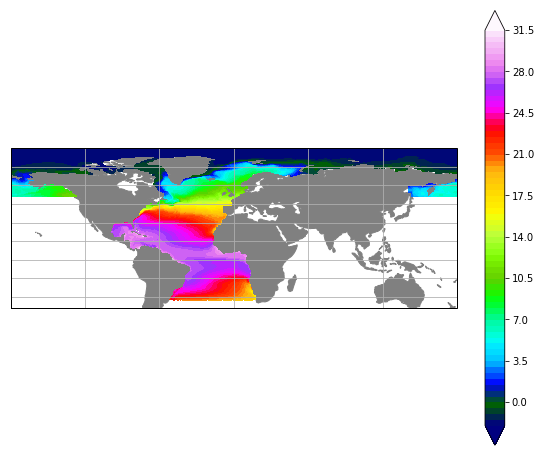

In [42]:
fig = MITgcm_recipes.plot_ASTE_pyresample(clim['THETA'].sel(k=0), 
                                          dict_plt_sst, 
                                          proj=cart.crs.PlateCarree())

In [50]:
fig.savefig('test.eps')

In [49]:
clim['THETA'].sel(k=0).to_netcdf('myplotfile.nc')